In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
import switch_detection_sweep_penalty_one_session as sdspos

In [310]:
row = subdb.iloc[8]
row

data_dir_full     /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...
sess_name                                            e16_3m2_211213
animal_name.1                                               e16_3m2
date                                                     2021-12-13
behavior                              ['alternation' 'alternation']
performance                                                0.703704
ntrials                                                          54
ngoodtrials                                                      54
n_neurons                                                       207
n_pyr_putative                                                  163
owner                                                         roman
data_root                                                roman_data
Name: (e16_3m2, 3), dtype: object

In [252]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
# pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
# fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
# occu_map_all = prepped_data_agg['occu_map_all']
# fr_map_all = prepped_data_agg['fr_map_all']

# pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# # corr_all = prepped_data_agg['corr_all']
# all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
# spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

# ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
# ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 
del prepped_data_agg


In [311]:
ani,sess,data_dir_full = row['animal_name.1'],row['sess_name'],row['data_dir_full']
all_sw_with_metrics = all_sw_with_metrics_d_all.loc[ani,sess]
X_pwc = X_pwc_all.loc[ani,sess]
X_raw = X_raw_all.loc[ani,sess]
all_fields_one_sess = all_fields_recombined_all.loc[ani,sess]


/tmp/ipykernel_600895/3999287029.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics = all_sw_with_metrics_d_all.loc[ani,sess]
/tmp/ipykernel_600895/3999287029.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc = X_pwc_all.loc[ani,sess]
/tmp/ipykernel_600895/3999287029.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[ani,sess]
/tmp/ipykernel_600895/3999287029.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_one_sess = all_fields_recombined_all.loc[ani,sess]


In [312]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220119"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="e15_13f1_220120"')['data_dir_full'][0]


# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


In [313]:
index_within_to_trial_index_df=dpp.index_within_to_trial_index(spk_beh_df)

reload(pa)
cell_cols = cell_cols_d['pyr']
speed_thresh=0.5
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide','average'])
fr_map_d={k:val[0] for k,val in fr_map_dict.items()}
fr_map_df_all = pd.concat(fr_map_d,axis=0)

fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_all=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


gpb=fr_map_trial_df_all.groupby(level=(0,1),sort=False,group_keys=False)
fr_map_trial_df_all_=[]
for k,val in gpb:
    fr_map_trial_df_all_.append(val[index_within_to_trial_index_df.loc[k].index])
fr_map_trial_df_all_ = pd.concat(fr_map_trial_df_all_,axis=0)
fr_map_trial_df_all = fr_map_trial_df_all_


cell_cols = cell_cols_d['int']
speed_thresh=0.5
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide','average'])
fr_map_d={k:val[0] for k,val in fr_map_dict.items()}
fr_map_df_all_int = pd.concat(fr_map_d,axis=0)

fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_all_int=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)

gpb=fr_map_trial_df_all_int.groupby(level=(0,1),sort=False,group_keys=False)
fr_map_trial_df_all_int_=[]
for k,val in gpb:
    fr_map_trial_df_all_int_.append(val[index_within_to_trial_index_df.loc[k].index])
fr_map_trial_df_all_int_ = pd.concat(fr_map_trial_df_all_int_,axis=0)
fr_map_trial_df_all_int = fr_map_trial_df_all_int_


fr_map_trial_df_all_both=pd.concat([fr_map_trial_df_all_int,fr_map_trial_df_all],axis=0).sort_index(level=2)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [314]:
cell_cols = cell_cols_d['pyr']
speed_thresh=0.5
fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='task_index',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_bothtt_pyr=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_trial_d.keys()},axis=0)

val_l=[]
for k,val in fr_map_trial_df_bothtt_pyr.groupby(level=0):

    val_l.append(val.loc[:,index_within_to_trial_index_df.loc[k].sort_values().values])

fr_map_trial_df_bothtt_pyr = pd.concat(val_l,axis=0)


cell_cols = cell_cols_d['int']
speed_thresh=0.5
fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='task_index',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
# fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_bothtt_int=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_trial_d.keys()},axis=0)
val_l=[]
for k,val in fr_map_trial_df_bothtt_int.groupby(level=0):
    
    val_l.append(val.loc[:,index_within_to_trial_index_df.loc[k].sort_values().values])
fr_map_trial_df_bothtt_int = pd.concat(val_l,axis=0)
# fr_map_trial_df_bothtt_int=fr_map_trial_df_bothtt_int[index_within_to_trial_index_df.sort_values().values]



cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [315]:
fr_map_trial_df_bothtt_int_ = copy.copy(fr_map_trial_df_bothtt_int)
fr_map_trial_df_bothtt_int_['trialtype']='both'
fr_map_trial_df_bothtt_int_=fr_map_trial_df_bothtt_int_.set_index('trialtype',append=True).swaplevel(3,2).swaplevel(2,1)

fr_map_trial_df_int_combined=pd.concat([fr_map_trial_df_all_int,fr_map_trial_df_bothtt_int_])

In [100]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [186]:
import peer_prediction as pp
reload(pp)
all_fields_one_sess = all_fields_recombined_all.loc[ani,sess]
mean_within_field_pred_all,glm_res_df_all,r2_all = pp.sweep_fit_glm_predict_rate_change(spk_beh_df,all_sw_with_metrics,all_fields_one_sess,
                                    index_within_to_trial_index_df,
                                    fr_map_trial_df_bothtt_int,
                                    fr_map_trial_df_all_int,
                                    cell_cols_d,                                        
                                    do_inh_only=True,
                                    do_weighted_pred=False,
                                    pval_thresh=None,
                                    ti=0)

/tmp/ipykernel_600895/786466990.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_one_sess = all_fields_recombined_all.loc[ani,sess]


In [187]:
reload(pp)
per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]
all_sw_with_metrics_oneti_with_inh_change= pp.add_inh_fr_change_to_all_sw(all_sw_with_metrics,mean_within_field_pred_all,per_field_metrics_one,ti=0)





/tmp/ipykernel_600895/84119525.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]


# examples of co switch

In [ ]:
ii=5
ti=0

all_sw_with_metrics_oneti_with_inh_change_onesw = all_sw_with_metrics_oneti_with_inh_change.query('switch==1')

# inds=all_sw_with_metrics_oneti_with_inh_change_onesw.sort_values('inh_fr_change').index
# row=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change>0').sort_values('inh_fr_change',ascending=False).iloc[ii]
row=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change<0').sort_values('inh_fr_change').iloc[ii]
tt,uid,field_id = row[['trialtype','uid','field_index']]
r2 = r2_all.loc[tt,uid,field_id]
print(r2)

reload(pp)
if tt=='both':
    fr_map_trial_df_exog = fr_map_trial_df_bothtt_int.loc[ti]
else:
    fr_map_trial_df_exog = fr_map_trial_df_all_int.loc[(ti,tt),:]
fr_map_one_tt_predictor = fr_map_trial_df_exog

if tt=='both':
    fr_map_trial_df_all_for_plot = fr_map_trial_df_bothtt_pyr
else:
    fr_map_trial_df_all_for_plot = fr_map_trial_df_all
mean_within_field_pred = mean_within_field_pred_all.loc[tt,uid,field_id]

do_weighted_pred=False
reload(pp)

inh_coef_ma = glm_res_df_all.loc[(tt,uid,field_id),'coef'] < 0
pp.post_fit_plot(mean_within_field_pred,
            all_fields_one_sess,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred,
             inh_coef_ma=inh_coef_ma
            )

In [200]:
ma=np.abs(all_fields_one_sess.loc[tt,ti]['peak'] - 68)<5
jj=5
row=all_fields_one_sess.loc[tt,ti].loc[ma].iloc[jj]
uid,field_id=row.name


In [201]:
all_fields_one_sess.loc[tt,ti].loc[ma].iloc[jj]

start                      58
end                        74
com                        66
peak                       68
fr_peak              4.764295
fr_mean              3.466057
other_field_index         NaN
Name: (150, 0), dtype: object

0.01360476980890224


(<Figure size 576x864 with 5 Axes>,
 array([<Axes: >,
        <Axes: title={'center': 'cell 150 field 0'}, xlabel='Trial', ylabel='Mean selected Int. FR'>,
        <Axes: xlabel='Trial', ylabel='Mean FR'>], dtype=object))

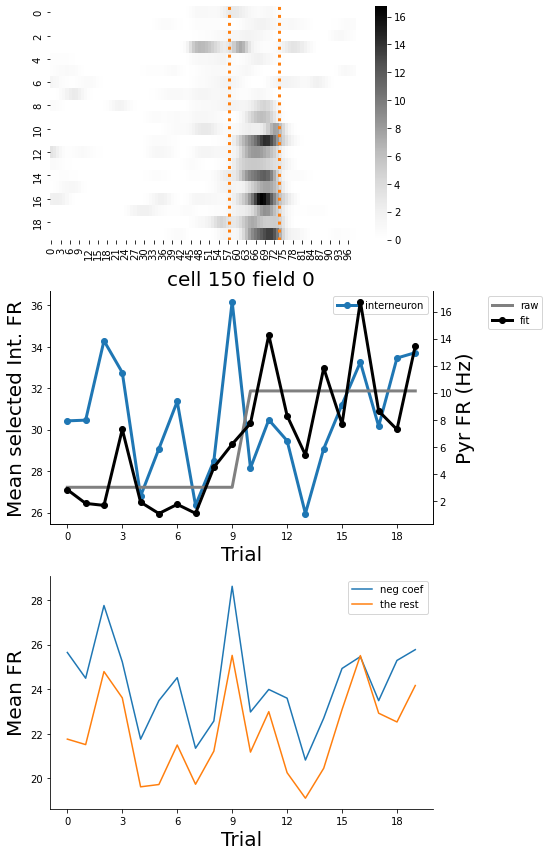

In [202]:
# ii=5
ti=0

# all_sw_with_metrics_oneti_with_inh_change_onesw = all_sw_with_metrics_oneti_with_inh_change.query('switch==1')

# inds=all_sw_with_metrics_oneti_with_inh_change_onesw.sort_values('inh_fr_change').index
# row=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change>0').sort_values('inh_fr_change',ascending=False).iloc[ii]
# row=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change<0').sort_values('inh_fr_change').iloc[ii]

# row=all_sw_with_metrics_oneti_with_inh_change_onesw.loc[113]
# tt,uid,field_id = row[['trialtype','uid','field_index']]

try:
    r2 = r2_all.loc[tt,uid,field_id]
    print(r2)
except:
    print('no fitting')
    
    
reload(pp)
if tt=='both':
    fr_map_trial_df_exog = fr_map_trial_df_bothtt_int.loc[ti]
else:
    fr_map_trial_df_exog = fr_map_trial_df_all_int.loc[(ti,tt),:]
fr_map_one_tt_predictor = fr_map_trial_df_exog

if tt=='both':
    fr_map_trial_df_all_for_plot = fr_map_trial_df_bothtt_pyr
else:
    fr_map_trial_df_all_for_plot = fr_map_trial_df_all
try:
    mean_within_field_pred = mean_within_field_pred_all.loc[tt,uid,field_id]
    inh_coef_ma = glm_res_df_all.loc[(tt,uid,field_id),'coef'] < 0
except:
    mean_within_field_pred=None
    inh_coef_ma = None
        

do_weighted_pred=False
reload(pp)


pp.post_fit_plot(mean_within_field_pred,
            all_fields_one_sess,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred,
             inh_coef_ma=inh_coef_ma
            )

In [195]:
mean_int_fr_one=fr_map_one_tt_predictor.loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values

pyr_fr_one=X_raw.loc[ti,tt,uid,field_id].dropna().values

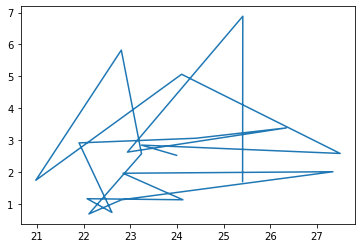

In [199]:
plt.plot(mean_int_fr_one,pyr_fr_one)

# downward upward tick and consecutive trial FR change

In [316]:
ti =0
n_lasting_trial=4

consec_trial_fr_diff_all = {}
do_norm=True
for (tt,uid,field_id),row in all_fields_one_sess.loc[ti].iterrows():
    st,ed = row['start'],row['end']
    pyr_fr_trial_within_field = X_raw.loc[(ti,tt,uid,field_id),:].dropna().values
    if do_norm:
        pyr_fr_trial_within_field = pyr_fr_trial_within_field / np.max(pyr_fr_trial_within_field)
        
    pyr_fr_prior_l = []
    for ii in range(1,len(pyr_fr_trial_within_field)):
        pyr_fr_prior = np.mean(pyr_fr_trial_within_field[:ii])
        pyr_fr_prior_l.append(pyr_fr_prior)
    pyr_fr_prior_l.append(np.nan)
    pyr_fr_prior_l = np.array(pyr_fr_prior_l)
    
    inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
    inh_fr_trial_within_field_diff = np.diff(inh_fr_trial_within_field,append=np.nan)
    diff_l = {}
    diff_l['inh'] = inh_fr_trial_within_field_diff
    for kk in range(1,n_lasting_trial+1):
#         pyr_diff = np.diff(pyr_fr_trial_within_field,n=kk,append=[np.nan]*kk)
        pyr_diff=pyr_fr_trial_within_field[kk:] - pyr_fr_trial_within_field[:-kk]
        pyr_diff=np.append(pyr_diff,[np.nan]*kk)
        diff_l[f'pyr_{kk}'] = pyr_diff
    diff_l = pd.DataFrame(diff_l)
    diff_l['fr_prior'] = pyr_fr_prior_l
    consec_trial_fr_diff_all[(tt,uid,field_id)] = diff_l
    
consec_trial_fr_diff_all = pd.concat(consec_trial_fr_diff_all,axis=0).dropna(axis=0)

/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_fie

/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_fie

/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_fie

/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_fie

/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_fie

/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/tmp/ipykernel_600895/907559116.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_fie

<IPython.core.display.Javascript object>


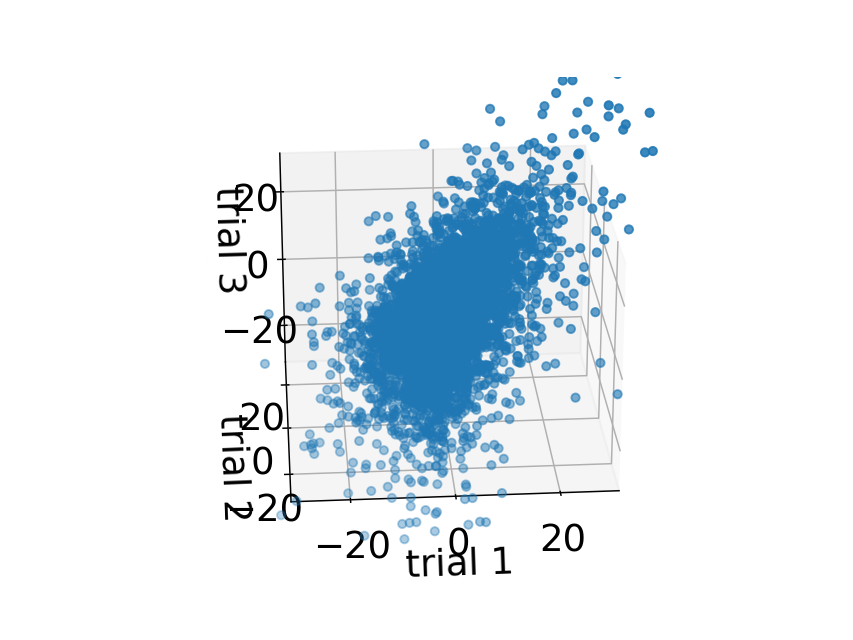

[(-30.0, 30.0), (-30.0, 30.0), (-30.0, 30.0)]

In [288]:
# %matplotlib notebook
# ax = plt.figure().add_subplot(projection='3d')
# ax.scatter(consec_trial_fr_diff_all['pyr_1'],consec_trial_fr_diff_all['pyr_2'],consec_trial_fr_diff_all['pyr_3'])
# ax.set_xlabel('trial 1')
# ax.set_ylabel('trial 2')
# ax.set_zlabel('trial 3')
# ax.set(xlim=[-30,30],ylim=[-30,30],zlim=[-30,30])

In [294]:
consec_trial_fr_diff_all.columns

Index(['inh', 'pyr_1', 'pyr_2', 'pyr_3'], dtype='object')

In [379]:
import matplotlib.colors as mcolors
toplot=consec_trial_fr_diff_all
colorcol = 'inh'
# normed_c_val=mcolors.TwoSlopeNorm(0)(toplot[colorcol])
normed_c_val = toplot[colorcol]/toplot[colorcol].abs().max()
c_l=plt.cm.Spectral(normed_val)

<IPython.core.display.Javascript object>


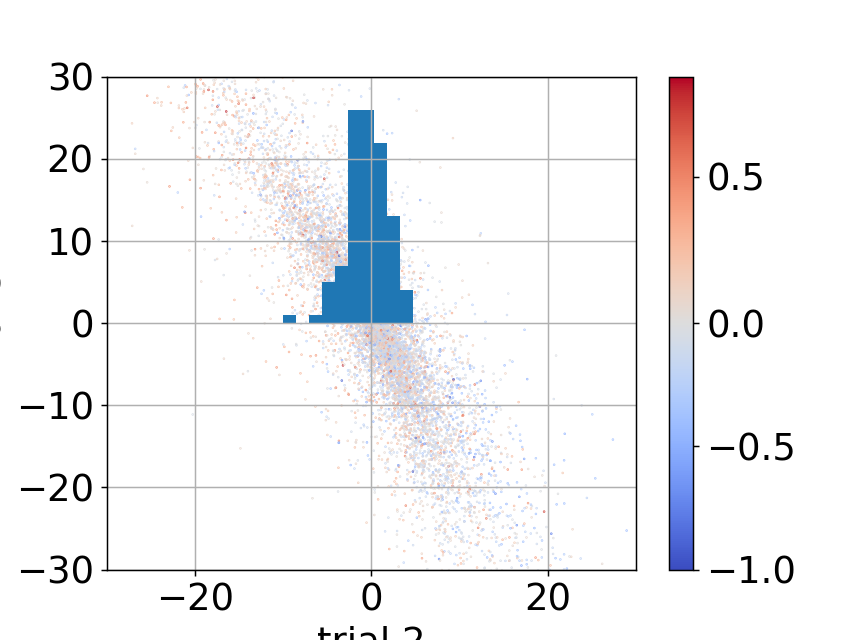

In [328]:
# %matplotlib notebook
# ax = plt.figure().add_subplot()
# norm = mcolors.TwoSlopeNorm(0)
# sc=ax.scatter(consec_trial_fr_diff_all['pyr_2'],consec_trial_fr_diff_all['pyr_3'],c=normed_c_val,cmap='coolwarm',s=0.1,norm=norm)
# ax.set_xlabel('trial 2')
# ax.set_ylabel('trial 3')
# # ax.set_zlabel('trial 3')
# ax.set(xlim=[-30,30],ylim=[-30,30])
# plt.colorbar(sc)

In [450]:
import plotly.express as px
import numpy as np


x_key = 'pyr_1'
y_key='pyr_5'
z_key = 'pyr_3'
toplot=consec_trial_fr_diff_all.query('pyr_1>0.5')
colorcol = 'inh'
# Create a scatter plot in Plotly using plotly.express
fig = px.scatter(x=toplot[x_key], y=toplot[y_key], color=toplot[colorcol], color_continuous_scale='RdBu_r',color_continuous_midpoint=0,
                labels={'x': x_key, 'y': y_key}
                )

# fig = px.scatter_3d(x=toplot[x_key], y=toplot[y_key],z=toplot[z_key], color=toplot[colorcol], color_continuous_scale='RdBu_r',color_continuous_midpoint=0,
#                 labels={'x': x_key, 'y': y_key,'z':z_key}
#                 )

marker_size = 5
fig.update_traces(marker=dict(size=marker_size))


fig.show()


In [348]:
# ma=(consec_trial_fr_diff_all.loc[:,'pyr_1':f'pyr_{n_lasting_trial}']>0.3).all(axis=1)
# ma=(consec_trial_fr_diff_all.loc[:,'pyr_1':f'pyr_4']>0.5).all(axis=1)
ma=(consec_trial_fr_diff_all['pyr_1']>0.4)&(consec_trial_fr_diff_all['pyr_2']<0.1)
# ma=(consec_trial_fr_diff_all['pyr_1']>0.3)&((consec_trial_fr_diff_all.loc[:,'pyr_2':'pyr_4']>0.3).all(axis=1))



WilcoxonResult(statistic=3915.0, pvalue=0.001444436441286524)

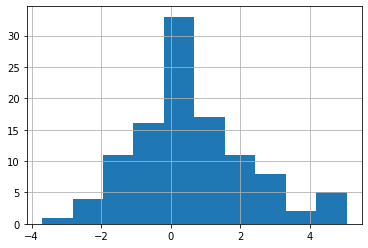

In [349]:
%matplotlib inline
consec_trial_fr_diff_all.loc[ma]['inh'].hist()
# scipy.stats.wilcoxon(consec_trial_fr_diff_all.loc[ma]['inh'],alternative='less')
scipy.stats.wilcoxon(consec_trial_fr_diff_all.loc[ma]['inh'],alternative='greater')

<Axes: xlabel='inh', ylabel='fr_prior'>

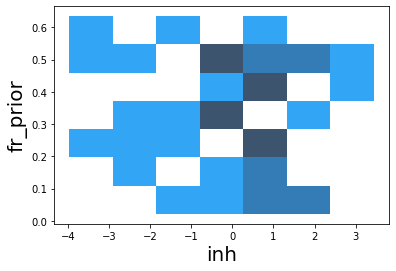

In [302]:
sns.histplot(data=consec_trial_fr_diff_all.loc[ma],x='inh',y='fr_prior')

In [544]:
jj=8
row=consec_trial_fr_diff_all.loc[ma].iloc[jj]
tt,uid,field_id,trial_within_min_1 = row.name
print(row['inh'])
print(trial_within_min_1+1)
print(row['fr_prior'])

-0.3389961066723828
3
0.022015436152817577


0.008925453993681831


(<Figure size 576x864 with 5 Axes>,
 array([<Axes: >,
        <Axes: title={'center': 'cell 183 field 0'}, xlabel='Trial', ylabel='Mean selected Int. FR'>,
        <Axes: xlabel='Trial', ylabel='Mean FR'>], dtype=object))

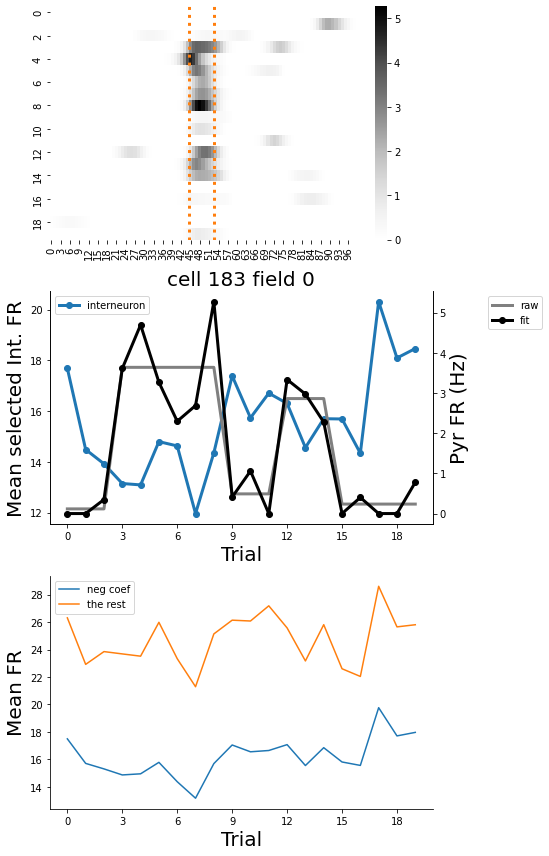

In [545]:
# ii=5
ti=0

# all_sw_with_metrics_oneti_with_inh_change_onesw = all_sw_with_metrics_oneti_with_inh_change.query('switch==1')

# inds=all_sw_with_metrics_oneti_with_inh_change_onesw.sort_values('inh_fr_change').index
# row=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change>0').sort_values('inh_fr_change',ascending=False).iloc[ii]
# row=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change<0').sort_values('inh_fr_change').iloc[ii]

# row=all_sw_with_metrics_oneti_with_inh_change_onesw.loc[113]
# tt,uid,field_id = row[['trialtype','uid','field_index']]

try:
    r2 = r2_all.loc[tt,uid,field_id]
    print(r2)
except:
    print('no fitting')
    
    
reload(pp)
if tt=='both':
    fr_map_trial_df_exog = fr_map_trial_df_bothtt_int.loc[ti]
else:
    fr_map_trial_df_exog = fr_map_trial_df_all_int.loc[(ti,tt),:]
fr_map_one_tt_predictor = fr_map_trial_df_exog

if tt=='both':
    fr_map_trial_df_all_for_plot = fr_map_trial_df_bothtt_pyr
else:
    fr_map_trial_df_all_for_plot = fr_map_trial_df_all
try:
    mean_within_field_pred = mean_within_field_pred_all.loc[tt,uid,field_id]
    inh_coef_ma = glm_res_df_all.loc[(tt,uid,field_id),'coef'] < 0
except:
    mean_within_field_pred=None
    inh_coef_ma = None
        

do_weighted_pred=False
reload(pp)


pp.post_fit_plot(mean_within_field_pred,
            all_fields_one_sess,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred,
             inh_coef_ma=inh_coef_ma
            )

# perhaps if a big jump up in pyr is accompanied by disinhibition, then the jump more likely to sustain?

WilcoxonResult(statistic=164067.0, pvalue=6.958553706624973e-32)

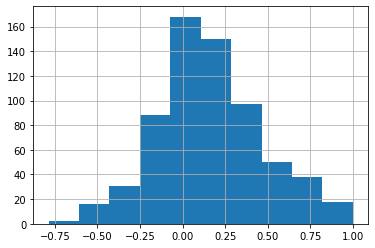

In [303]:
pyr_up_threh = 0
inh_thresh = 0
ma=(consec_trial_fr_diff_all['pyr_1'] > pyr_up_threh) & (consec_trial_fr_diff_all['inh'] < inh_thresh)
xx=consec_trial_fr_diff_all.loc[ma]['pyr_2']
xx.hist()
scipy.stats.wilcoxon(xx,alternative='greater')

WilcoxonResult(statistic=130041.0, pvalue=7.580624757991477e-26)

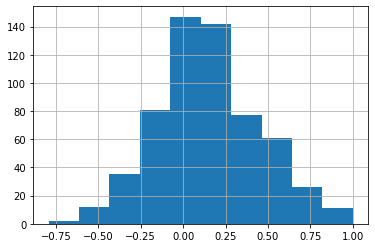

In [304]:
ma=(consec_trial_fr_diff_all['pyr_1'] > pyr_up_threh) & (consec_trial_fr_diff_all['inh'] > inh_thresh)
xx=consec_trial_fr_diff_all.loc[ma]['pyr_2']
xx.hist()
scipy.stats.wilcoxon(xx,alternative='greater')

In [397]:
import sw_and_int_one_sess as sios
reload(sios)
# test_res_d = sios.post_tests(consec_trial_fr_diff_all)
test_res_d = sios.main(data_dir_full)

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/sw_res_afterheadscan.p exists; loading---


/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects

/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects

/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects

/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects

/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects

/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  inh_fr_trial_within_field = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all').loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().mean(axis=0).values
/mnt/home/szheng/projects

saved at /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/sw_and_int.p


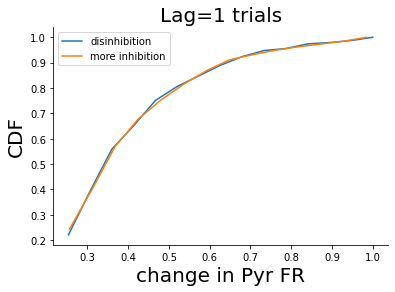

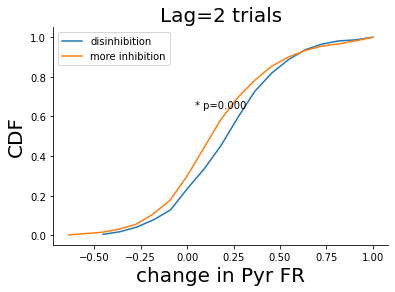

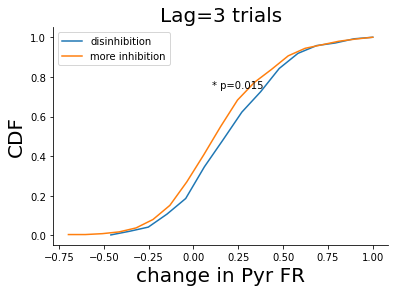

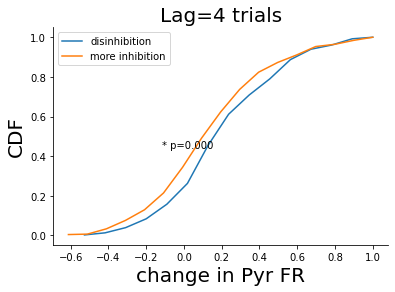

In [381]:
pyr_up_threh = 0.2
inh_thresh=0.
for kk in range(1,5):
    ma=(consec_trial_fr_diff_all['pyr_1'] > pyr_up_threh) & (consec_trial_fr_diff_all['inh'] < inh_thresh)
    xx=consec_trial_fr_diff_all.loc[ma][f'pyr_{kk}']
    ma=(consec_trial_fr_diff_all['pyr_1'] > pyr_up_threh) & (consec_trial_fr_diff_all['inh'] > -inh_thresh)
    yy=consec_trial_fr_diff_all.loc[ma][f'pyr_{kk}']
    fig,ax=ph.plot_cdf_and_ks_test(xx,yy,label1='disinhibition',label2='more inhibition',xlabel='change in Pyr FR',title=f'Lag={kk} trials')

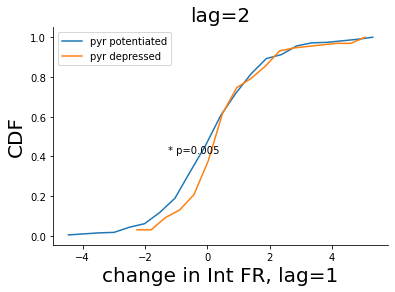

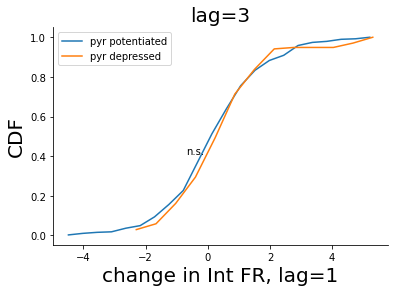

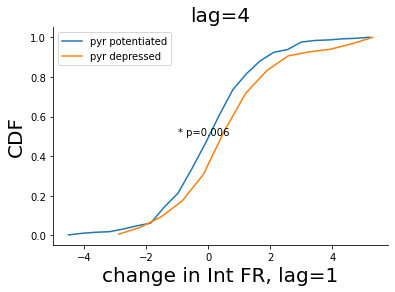

In [320]:
### another hypothesis: if inhibition is accompanied with a multi trial potentiation, then the first potention must be big
### actually: increase in one trial would predict increase in the next, at baseline

pyr_up_thresh_1=0.3
pyr_up_thresh_2=0.
for k in range(2,5):
    ma=(consec_trial_fr_diff_all['pyr_1'] > pyr_up_thresh_1) &(consec_trial_fr_diff_all[f'pyr_{k}'] > pyr_up_thresh_2) 
    xx=consec_trial_fr_diff_all.loc[ma][f'inh']
    ma=(consec_trial_fr_diff_all['pyr_1'] > pyr_up_thresh_1) &(consec_trial_fr_diff_all[f'pyr_{k}'] < -pyr_up_thresh_2) 
    yy=consec_trial_fr_diff_all.loc[ma][f'inh']
    fig,ax=ph.plot_cdf_and_ks_test(xx,yy,label1='pyr potentiated',label2='pyr depressed',xlabel=f'change in Int FR, lag=1',title=f'lag={k}')




WilcoxonResult(statistic=18292901.0, pvalue=6.653382978804205e-10)

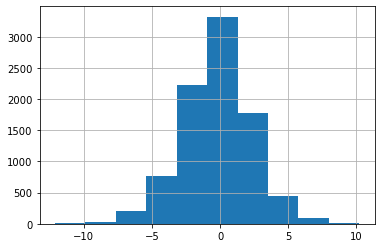

In [491]:
# consec_trial_fr_diff_all['inh'].hist()
# scipy.stats.wilcoxon(consec_trial_fr_diff_all['inh'],alternative='less')

# visualize: within a bin, for each pyr, avg fr across trials; for mean int, fr across trials

In [18]:
lin_bin_win = np.arange(0,99,10)
lin_bin_win = np.append(lin_bin_win,lin_bin_win[-1]+10)

In [19]:
lin_bin_win

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [43]:
int_across_trial_allwin_alltt = {}
pyr_across_trial_allwin_alltt={}
for k,val in fr_map_trial_df_all_int.groupby(level=(0,1)):
    int_across_trial_allwin={}
    pyr_across_trial_allwin={}
    for i in range(len(lin_bin_win)-1):
        st,ed=lin_bin_win[i],lin_bin_win[i+1]
        int_across_trial_per_win=val.loc[k].loc[(slice(None),slice(st,ed)),:].mean(axis=0).dropna()
        pyr_across_trial_per_win =fr_map_trial_df_all.loc[k].loc[(slice(None),slice(st,ed)),:].groupby(level=0).mean().dropna(axis=1,how='all')
        int_across_trial_allwin[i] = int_across_trial_per_win
        pyr_across_trial_allwin[i] = pyr_across_trial_per_win
    int_across_trial_allwin = pd.concat(int_across_trial_allwin)
    int_across_trial_allwin_alltt[k] = int_across_trial_allwin
    pyr_across_trial_allwin = pd.concat(pyr_across_trial_allwin)
    pyr_across_trial_allwin_alltt[k] = pyr_across_trial_allwin
    
    
int_across_trial_allwin_alltt = pd.concat(int_across_trial_allwin_alltt,axis=0)
int_across_trial_allwin_alltt= int_across_trial_allwin_alltt.unstack()
pyr_across_trial_allwin_alltt = pd.concat(pyr_across_trial_allwin_alltt,axis=0)



In [82]:
mean_fr_per_pyr = fr_map_trial_df_all.groupby(level=(0,1,2)).max().max(axis=1)

In [99]:
int_across_trial_allwin_alltt

0          1          2          3          4          5   \
0 0.0 0  28.698161  29.228511  26.487897  23.326819  22.176907  23.788975   
      1  26.398107  27.592566  26.000544  25.570744  23.282398  24.381980   
      2  24.501625  25.407014  25.086288  25.355467  22.140484  23.212570   
      3  26.358861  24.976593  23.631172  23.799207  22.658915  21.778173   
      4  22.828659  20.427015  19.887760  18.930254  18.562207  20.191245   
      5  21.825914  19.433001  20.501694  20.852365  18.371951  17.883864   
      6  23.414925  22.978269  25.495662  24.987202  20.658612  20.952425   
      7  24.650454  23.460765  29.727908  23.243516  21.484620  24.790979   
      8  22.712009  23.393142  25.808772  28.507167  21.930043  22.845514   
      9  25.773177  23.922135  23.799576  29.821010  24.944694  22.968124   
  1.0 0  30.724814  22.957124  22.853511  23.355000  24.193875  26.460727   
      1  27.576626  26.772391  24.872416  26.856610  25.157287  23.329752   
      2  25.070474  28.366634  24.969866  25.737231  23.674267  23.738470   
      3  23.895529  24.359483  22.839873  22.579582  21.979820  21.158050   
      4  21.543141  18.650518  18.366725  20.133981  19.732610  22.210315   
      5  22.340836  19.228089  20.559760  19.696966  20.617751  23.467258   
      6  22.800752  21.402920  22.424907  19.605902  19.790297  22.102338   
      7  24.379324  23.020952  22.230087  20.692533  24.031420  21.563117   
      8  26.758960  19.231061  23.218833  24.160295  23.829070  22.430490   
      9  23.634500  25.724283  26.240155  25.468894  24.243766  24.161780   

                6          7          8          9          10         11  \
0 0.0 0  22.945183  27.113018  21.389113  25.373808  23.583262  22.594744   
      1  25.649255  25.676498  22.374001  21.167953  28.979558  24.040920   
      2  24.755259  23.107163  22.283722  21.525135  25.928232  21.153912   
      3  24.436006  21.980246  23.488983  22.271665  24.927555  20.802996   
      4  21.020713  17.915492  19.729479  20.595588  21.592187  23.421386   
      5  16.574614  16.450486  19.448712  21.654399  19.830521  18.991033   
      6  23.641809  19.995631  21.263092  26.395574  21.340917  23.485110   
      7  23.063280  24.280655  24.431219  28.442088  24.435152  24.857840   
      8  24.321098  23.604934  22.712950  25.783374  22.022691  24.272872   
      9  23.793765  22.545638  25.927734  27.138049  22.514071  22.817729   
  1.0 0  28.705931  22.573676  24.505879  23.904459  22.934266  20.772529   
      1  25.908116  23.199911  22.723749  24.857633  25.643956  22.538307   
      2  23.301727  25.300759  23.210908  24.791499  22.155510  22.532465   
      3  22.281666  21.740796  22.822463  20.932293  20.254326  22.985374   
      4  23.301720  21.512596  18.782870  19.771493  21.286624  20.259249   
      5  22.874340  20.814013  19.627364  21.000309  22.628007  20.551671   
      6  22.513282  19.852654  18.122390  20.173637  19.531962  21.567882   
      7  29.237523  21.732718  29.588131  22.827284  21.783875  26.648815   
      8  27.834680  19.896758  24.877778  22.736802  20.019189  21.410828   
      9  23.393217  22.579378  24.244487  23.319074  21.359450  21.839148   

                12         13         14         15         16         17  \
0 0.0 0  25.513654  26.196014  21.396371  23.920927  28.147063  21.084536   
      1  23.816967  26.684921  21.760640  22.707414  21.375316  22.932540   
      2  23.423223  22.802177  23.300798  22.618541  22.748311  21.427438   
      3  22.854654  22.178042  22.482699  23.933676  22.616393  21.925043   
      4  21.092197  20.324713  20.918311  21.546356  19.608541  23.534563   
      5  21.479236  18.129203  21.178827  17.358581  18.099558  20.576110   
      6  21.660587  17.816479  20.761115  23.659938  25.447542  23.313780   
      7  22.552084  27.238706  23.065497  25.343785  27.333736  22.619771   
      8  21.107510  25.381305  23.406595  19.791097  21.102733  21.590709   
      9  2

In [101]:
int_across_trial_allwin_alltt.loc[k]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,30.724814,22.957124,22.853511,23.355000,24.193875,26.460727,28.705931,22.573676,24.505879,23.904459,22.934266,20.772529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27.576626,26.772391,24.872416,26.856610,25.157287,23.329752,25.908116,23.199911,22.723749,24.857633,25.643956,22.538307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.070474,28.366634,24.969866,25.737231,23.674267,23.738470,23.301727,25.300759,23.210908,24.791499,22.155510,22.532465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.895529,24.359483,22.839873,22.579582,21.979820,21.158050,22.281666,21.740796,22.822463,20.932293,20.254326,22.985374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21.543141,18.650518,18.366725,20.133981,19.732610,22.210315,23.301720,21.512596,18.782870,19.771493,21.286624,20.259249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,22.340836,19.228089,20.559760,19.696966,20.617751,23.467258,22.874340,20.814013,19.627364,21.000309,22.628007,20.551671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,22.800752,21.402920,22.424907,19.605902,19.790297,22.102338,22.513282,19.852654,18.122390,20.173637,19.531962,21.567882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,24.379324,23.020952,22.230087,20.692533,24.031420,21.563117,29.237523,21.732718,29.588131,22.827284,21.783875,26.648815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,26.758960,19.231061,23.218833,24.160295,23.829070,22.430490,27.834680,19.896758,24.877778,22.736802,20.019189,21.410828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23.634500,25.724283,26.240155,25.468894,24.243766,24.161780,23.393217,22.579378,24.244487,23.319074,21.359450,21.839148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


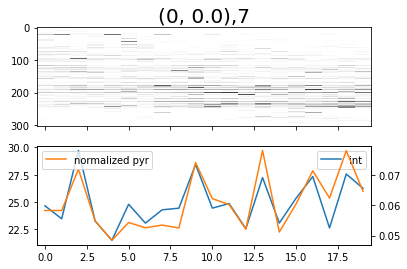

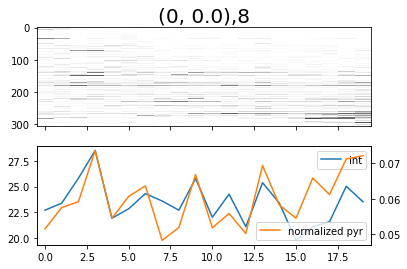

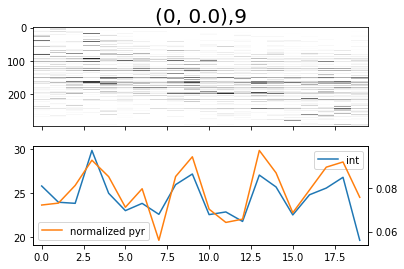

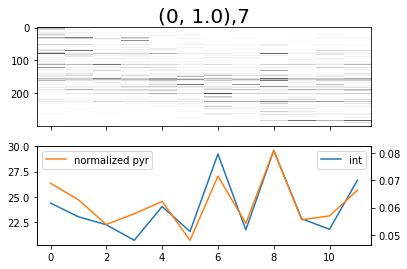

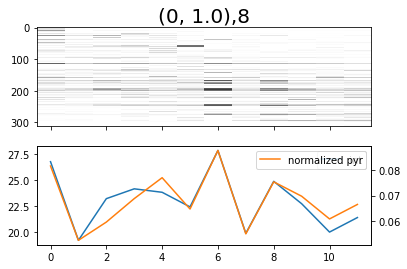

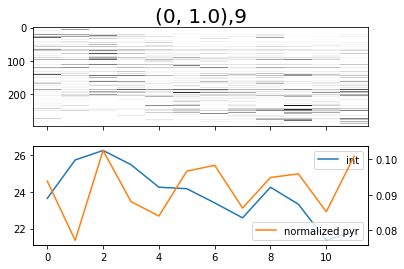

In [128]:
for k, val in pyr_across_trial_allwin_alltt.groupby(level=(0,1)):
    pyr_onett=val.loc[k].dropna(axis=1,how='all')
    to_norm = mean_fr_per_pyr.loc[k].values
#     fig,axs=ph.subplots_wrapper(len(pyr_onett.groupby(level=0)))
#     for ii,(poswin, valval) in enumerate(pyr_onett.groupby(level=0)):
    for poswin in [7,8,9]:
        valval = val.loc[k]
        fig,axs = plt.subplots(2,1,sharex=True)
        ax=axs[0]
        pyr_oneposwin_across_trials_norm=valval.loc[poswin].dropna(axis=1,how='all') / to_norm[:,None]
        pyr_oneposwin_across_trials_norm_nonzero = pyr_oneposwin_across_trials_norm.loc[pyr_oneposwin_across_trials_norm.sum(axis=1)>0.001]
        to_avg=np.tile(pyr_oneposwin_across_trials_norm.columns,(pyr_oneposwin_across_trials_norm_nonzero.shape[0],1))
        com = np.average(to_avg,weights=pyr_oneposwin_across_trials_norm_nonzero,axis=1)
        pyr_oneposwin_across_trials_norm_nonzero=pyr_oneposwin_across_trials_norm_nonzero.iloc[np.argsort(com)]

#         ax=axs.ravel()[ii]
#         sns.heatmap(pyr_oneposwin_across_trials_norm_nonzero,ax=ax,cmap='Greys',vmin=0,vmax=1)
        ax.imshow(pyr_oneposwin_across_trials_norm_nonzero,cmap='Greys',vmin=0,vmax=1,aspect='auto',interpolation='none')
        ax.set_title(f'{k},{poswin}')
        ax=axs[1]
        ax.plot(int_across_trial_allwin_alltt.loc[k,:].loc[poswin].dropna(),label='int')
        ax2 = ax.twinx()
        ax2.plot(pyr_oneposwin_across_trials_norm_nonzero.mean(axis=0),c='C1',label='normalized pyr')
        ax.legend()
        ax2.legend()

# summary of similarity of coefficients

In [55]:

inh_ma = glm_res_df_all['coef'] < 0


from scipy.spatial.distance import pdist, squareform
inh_con_dist=pdist(inh_ma.T,metric='jaccard')
# plt.hist(inh_con_dist)
con_dist=pdist(glm_res_df_all['coef'].T,metric='cosine')
plt.hist(con_dist)

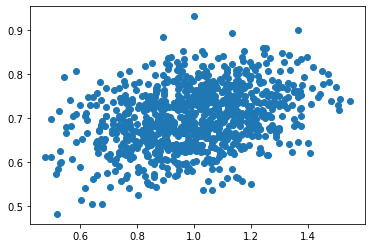

In [69]:
plt.scatter(con_dist,inh_con_dist)

In [60]:
inh_con_dist

array([0.76146789, 0.80582524, 0.78504673, 0.77142857, 0.78888889,
       0.77173913, 0.60638298, 0.68932039, 0.73148148, 0.7244898 ,
       0.79245283, 0.66292135, 0.81927711, 0.74468085, 0.68604651,
       0.75294118, 0.73563218, 0.70408163, 0.70707071, 0.79787234,
       0.63855422, 0.60714286, 0.7       , 0.625     , 0.74725275,
       0.61111111, 0.71875   , 0.71559633, 0.69791667, 0.81651376,
       0.64893617, 0.76744186, 0.75      , 0.73529412, 0.66972477,
       0.7244898 , 0.7047619 , 0.75      , 0.7027027 , 0.79090909,
       0.82178218, 0.75675676, 0.57142857, 0.72173913, 0.67272727,
       0.81132075, 0.67346939, 0.70175439, 0.72268908, 0.58715596,
       0.70909091, 0.64485981, 0.71698113, 0.77659574, 0.67647059,
       0.68686869, 0.74489796, 0.76699029, 0.66666667, 0.68181818,
       0.7       , 0.65979381, 0.75925926, 0.61320755, 0.52586207,
       0.71568627, 0.6728972 , 0.7826087 , 0.59821429, 0.70909091,
       0.64814815, 0.60194175, 0.69148936, 0.66363636, 0.68468

In [51]:
all_sw_with_metrics_oneti_with_inh_change

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_le_90_perc_frac_total,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total,inh_fr_change,fit_var_ratio,sparsity,mean
0,both,66,0,6684.468867,27.401026,25.0,2,1.0,1,2.0,...,0.8750,0.93750,0.90625,0.46875,0.18750,0.06250,-1.077994,0.710373,1.265996,15.441749
1,both,67,0,6683.535300,30.506287,8.0,2,1.0,1,2.0,...,0.6250,0.71875,0.71875,0.68750,0.43750,0.09375,-0.764157,0.542660,1.666003,19.180310
2,both,186,0,6684.402200,30.468344,24.0,2,1.0,1,2.0,...,0.1875,0.21875,0.21875,0.18750,0.09375,0.03125,-0.727079,0.695016,1.629435,4.521723
3,both,329,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.1250,0.21875,0.21875,0.21875,0.18750,0.09375,-1.764463,0.578723,2.015310,20.125519
4,both,349,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.2500,0.31250,0.31250,0.25000,0.21875,0.06250,-1.740035,0.658906,2.851918,15.024616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,181,1,8222.942500,11.502441,43.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.05000,0.05000,1.796924,0.638267,2.280955,2.517687
202,0.0,204,0,8220.241800,8.558946,35.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,0.320355,0.843652,4.206337,2.134234
203,0.0,250,0,8242.805858,19.295595,83.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.05000,0.05000,0.05000,3.013733,0.789125,4.886189,2.604224
204,0.0,313,1,8234.245367,15.980170,56.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,1.424314,0.684256,3.843273,5.948275


In [46]:
glm_res_df_all['coef'].T.corr()

0.0                                                    \
                 32        42                  55        60        61    
                   1         1         2         2         1         1   
0.0  32  1  1.000000 -0.059684 -0.059684  0.356323 -0.386000 -0.259342   
     42  1 -0.059684  1.000000  1.000000 -0.590243  0.517613  0.527875   
         2 -0.059684  1.000000  1.000000 -0.590243  0.517613  0.527875   
     55  2  0.356323 -0.590243 -0.590243  1.000000 -0.583289 -0.673515   
     60  1 -0.386000  0.517613  0.517613 -0.583289  1.000000  0.526743   
...              ...       ...       ...       ...       ...       ...   
both 329 0 -0.134685  0.415360  0.415360 -0.528256  0.305254  0.802250   
     349 0  0.366634 -0.420201 -0.420201  0.574459 -0.470087 -0.404163   
     354 0  0.060798  0.360157  0.360157 -0.451114  0.254151  0.477875   
     359 0 -0.041152 -0.050490 -0.050490  0.205586 -0.191428 -0.161204   
     376 0 -0.287235  0.402779  0.402779 -0.677489  0.600685  0.702448   

                                                    ...      both            \
                 68        71        73             ...       231       240   
                   0         0         0         1  ...         0         0   
0.0  32  1  0.080039 -0.183793 -0.356456 -0.356456  ... -0.256341  0.214608   
     42  1 -0.220542 -0.005503  0.417530  0.417530  ...  0.081639 -0.324074   
         2 -0.220542 -0.005503  0.417530  0.417530  ...  0.081639 -0.324074   
     55  2  0.491750 -0.298445 -0.714055 -0.714055  ... -0.103665  0.482531   
     60  1 -0.301699  0.081550  0.703738  0.703738  ...  0.026557 -0.507570   
...              ...       ...       ...       ...  ...       ...       ...   
both 329 0 -0.710885  0.289205  0.513567  0.513567  ...  0.407091  0.039229   
     349 0  0.269944 -0.121349 -0.631091 -0.631091  ...  0.088174  0.826230   
     354 0 -0.520437  0.101964  0.393189  0.393189  ...  0.315577  0.137858   
     359 0  0.016552 -0.110706 -0.170547 -0.170547  ... -0.080171  0.114135   
     376 0 -0.597199  0.188109  0.939944  0.939944  ...  0.124006 -0.549598   

                                                                        \
                 267       270       279       329       349       354   
                   0         0         0         0         0         0   
0.0  32  1  0.564799  0.034685  0.259895 -0.134685  0.366634  0.060798   
     42  1 -0.358848  0.165188 -0.423694  0.415360 -0.420201  0.360157   
         2 -0.358848  0.165188 -0.423694  0.415360 -0.420201  0.360157   
     55  2  0.424532 -0.190920  0.484850 -0.528256  0.574459 -0.451114   
     60  1 -0.581485  0.257237 -0.412630  0.305254 -0.470087  0.254151   
...              ...       ...       ...       ...       ...       ...   
both 329 0 -0.242513  0.284033 -0.436966  1.000000 -0.202889  0.535731   
     349 0  0.403722 -0.178302  0.469140 -0.202889  1.000000  0.097820   
     354 0 -0.033576  0.038772 -0.341278  0.535731  0.097820  1.000000   
     359 0  0.041098 -0.040778  0.073461 -0.121077  0.016371 -0.181088   
     376 0 -0.451017  0.467952 -0.493345  0.595638 -0.626571  0.345158   

                                
                 359       376  
                   0         0  
0.0  32  1 -0.041152 -0.287235  
     42  1 -0.050490  0.402779  
         2 -0.050490  0.402779  
     55  2  0.205586 -0.677489  
     60  1 -0.191428  0.600685  
...              ...       ...  
both 329 0 -0.121077  0.595638  
     349 0  0.016371 -0.626571  
     354 0 -0.181088  0.345158  
     359 0  1.000000 -0.103101  
     376 0 -0.103101  1.000000  

[142 rows x 142 columns]

In [42]:
glm_res_df_all['coef']

1         2         3         4         5         6    \
0.0  32  1  0.005079 -0.002869 -0.015170 -0.010691  0.001556  0.007875   
     42  1  0.012528 -0.000660  0.003594 -0.006805  0.007364  0.004887   
         2  0.012528 -0.000660  0.003594 -0.006805  0.007364  0.004887   
     55  2  0.000828  0.006260 -0.003136 -0.004119  0.007414  0.004857   
     60  1  0.000657 -0.001696  0.001632 -0.001421 -0.003815  0.001818   
...              ...       ...       ...       ...       ...       ...   
both 329 0 -0.005558  0.002805 -0.003883 -0.000077  0.002840 -0.004664   
     349 0  0.001813  0.000577 -0.001201 -0.002423  0.000191  0.001583   
     354 0 -0.003802  0.004415  0.006054 -0.007080 -0.002887  0.008543   
     359 0  0.011113  0.003240  0.006819 -0.006034  0.015325  0.002413   
     376 0  0.000269 -0.004393 -0.007646  0.005507  0.003596  0.003431   

                 7         8         9         10   ...       48        49   \
0.0  32  1  0.011321  0.002352 -0.004855 -0.015214  ...  0.010072 -0.000138   
     42  1 -0.001619  0.002521  0.001844 -0.005364  ... -0.007951  0.003631   
         2 -0.001619  0.002521  0.001844 -0.005364  ... -0.007951  0.003631   
     55  2  0.008824  0.005596 -0.005965 -0.004044  ...  0.001551 -0.001182   
     60  1  0.000475 -0.000098  0.002417 -0.001086  ... -0.002967  0.000803   
...              ...       ...       ...       ...  ...       ...       ...   
both 329 0  0.001762 -0.000570 -0.004950  0.014712  ... -0.011115 -0.002506   
     349 0  0.004658  0.004394  0.000533  0.005209  ... -0.002997 -0.003916   
     354 0 -0.001441  0.000725 -0.001936  0.011741  ...  0.001404  0.003478   
     359 0  0.005359  0.001681 -0.003120 -0.002064  ...  0.000003  0.001627   
     376 0 -0.001576  0.000115 -0.002438 -0.003652  ... -0.003674 -0.003116   

                 50        51        52        53        58        69   \
0.0  32  1  0.000792  0.003675  0.012053  0.008063 -0.013902 -0.003788   
     42  1  0.004726 -0.000366  0.005670  0.004443  0.006145  0.052622   
         2  0.004726 -0.000366  0.005670  0.004443  0.006145  0.052622   
     55  2 -0.002104  0.000474 -0.001196 -0.003191 -0.003821 -0.012091   
     60  1  0.002368  0.004019  0.001489 -0.002390 -0.000591  0.008242   
...              ...       ...       ...       ...       ...       ...   
both 329 0 -0.006397 -0.005242  0.001297  0.006150  0.025334 -0.001002   
     349 0  0.001629  0.001501 -0.005389  0.000255 -0.006362 -0.007764   
     354 0 -0.003460  0.009044 -0.003518  0.009368 -0.004403  0.009210   
     359 0 -0.000058 -0.000935  0.010061  0.005431  0.010984 -0.005851   
     376 0  0.000022 -0.003687 -0.002479 -0.000966 -0.004799 -0.008998   

                 109       205  
0.0  32  1  0.014775 -0.027216  
     42  1  0.024997  0.035562  
         2  0.024997  0.035562  
     55  2  0.001036 -0.028733  
     60  1  0.003408  0.015062  
...              ...       ...  
both 329 0  0.028936  0.052339  
     349 0  0.004423 -0.023363  
     354 0  0.011663  0.016818  
     359 0  0.000876 -0.002326  
     376 0 -0.005862  0.150253  

[142 rows x 43 columns]